Se analizaran los datos de Grupo Financiero Inbursa, desde el 7-02-2001 hasta 4-02-2021

4999
4999


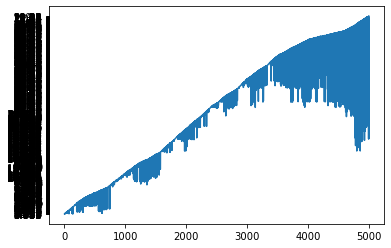

In [15]:
#Grupo Financiero Inbursa
import pywt, csv, numpy as np
import matplotlib.pyplot as plt

# Abrir el archivo CSV en modo lectura
with open('cierre.csv', newline='') as csvfile:

    # Crear un lector de CSV
    cierre = np.array(list(csv.reader(csvfile, delimiter=',')))

cierre = cierre.transpose()
cierre = np.delete(cierre, 0)
cierre = np.flip(cierre, axis= 0)
print(cierre.size)
x = np.arange(1, 5000)
print(x.size)

# Crear un gráfico de línea con los valores de x e y
plt.plot(x[:4999], cierre[:4999])

# Mostrar el gráfico
plt.show()

#Eleccion de Mother Wavelet

Se elige las mother wavelets dependiendo de las caracteristicas de la serie de tiempo que se va a analizar. Para series que impliquen cambios no periodicos y repentinos es recomendable usar Haar ya que responde bien a estos cambios repentinos.

Se elige bior3.5 debido a las caracteristicas de las fluctuaciones entre periodos con altas cantidades de inversiones y periodos en los que no.

En general, el mother wavelet debe de ser una funcion de las caracteristicas de la serie original para que esta pueda ser reconstruida o analizada 

2505
2505


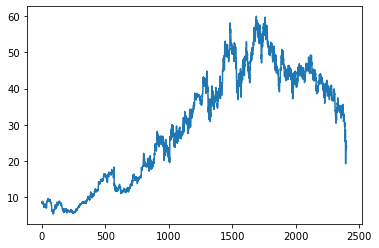

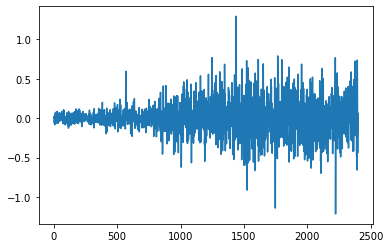

In [16]:
#Se descompone la lista de precios de cierre del intervalo mencionado anteriormente a partir de la dwt con la función bior3.5
(cA, cD) = pywt.dwt(cierre.tolist(), 'bior3.5')
print(cA.size)
print(cD.size)

plt.plot(x[:2400], cA[:2400])

# Mostrar el gráfico
plt.show()
plt.plot(x[:2400], cD[:2400])

# Mostrar el gráfico
plt.show()


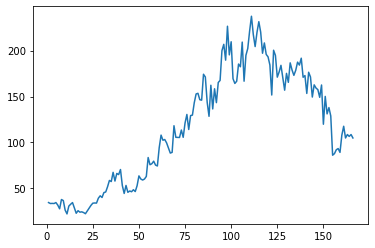

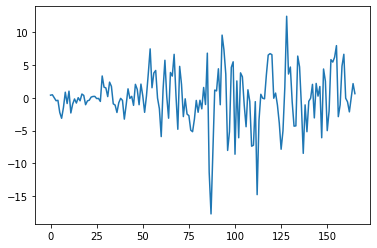

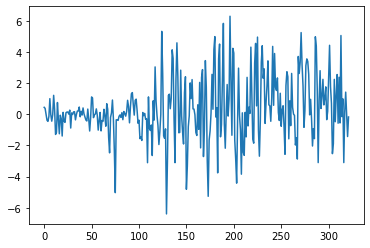

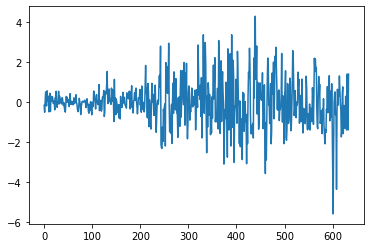

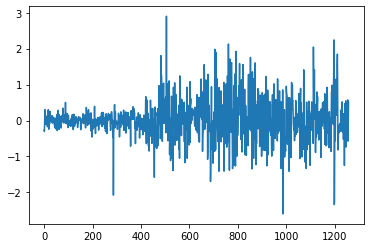

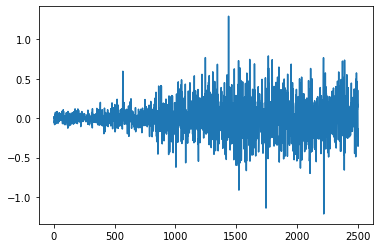

In [17]:
#Se realiza el proceso 5 veces
coeffs = pywt.wavedec(cierre, 'bior3.5', level=5)
cA = coeffs[0]
plt.plot(x[:166], cA)
plt.show()

cD_1 = coeffs[1]
cD_2 = coeffs[2]
cD_3 = coeffs[3]
cD_4 = coeffs[4]
cD_5 = coeffs[5]
plt.plot(range(166), cD_1)
plt.show()

plt.plot(range(322), cD_2)
plt.show()

plt.plot(range(634), cD_3)
plt.show()

plt.plot(range(1258), cD_4)
plt.show()

plt.plot(range(2505), cD_5)
plt.show()


In [18]:
#print(len(coeffs))
A5=coeffs[0]#coeficientes de analisis
D1=coeffs[1]#coeficientes de detalle
D2=coeffs[2]
D3=coeffs[3]
D4=coeffs[4]
D5=coeffs[5]


def normalizar(arr):
    """
    Normaliza cada uno de los elementos de un arreglo.
    """
    return np.vectorize(lambda x: (x-np.min(arr))/(np.max(arr)-np.min(arr)))(arr)

def desnormalizar(arr):
    """
    Elimina la normalización cada uno de los elementos de un arreglo.
    """
    return np.vectorize(lambda y: np.min(arr)*(-y) + np.min(arr) + np.max(arr)*y)(arr)

#Se normalizan cada uno de los elementos de los vectores contenidos en las descomposicion de la serie de tiempo original
coeffs_n = [normalizar(vect) for vect in coeffs]


#print(coeffs_n[0])
#Estos 6 arreglos representan la descomposición de la señal original. Se tendrán que armar 6 redes que predigan cada una de estas
#componentes, Las entradas correspondientes a cada una son las 8 semanas anteriores para calcular la novena

from sklearn.model_selection import train_test_split

entrenamiento = [0] * 6
prueba = [0] * 6
validacion = [0] * 6

#Se descompone cada uno de los conjuntos de coeficientes en conjuntos de entrenamiento, prueba y validación
def generar_conjuntos(coeficientes,c_validacion):
    for _ in range(len(coeficientes)):
        #train_data, test_data = train_test_split(coeffs_n[_], train_size=0.7, test_size=0.3, random_state=42)#random_state es la semilla
        split_index = int(len(coeficientes[_]) * 0.7)
        train_data = coeficientes[_][:split_index]
        test_data = coeficientes[_][split_index:]
        val_data = coeficientes[_][split_index:]
        #val_data, test_data = train_test_split(test_data, train_size=0.5, test_size=0.5, random_state=42)
        if (c_validacion):
            split_index = int(len(test_data) * 0.5)
            
            test_data = coeficientes[_][:split_index]
            val_data = coeficientes[_][split_index:]
        entrenamiento[_] = train_data
        prueba[_] = test_data
        validacion[_] = val_data

generar_conjuntos(coeffs_n,False)
print(len(entrenamiento[0]))


116


In [19]:
#Red Neuronal no lineal autoregresiva
#La estructura de la red es más que nada las entradas (los n valores anteriores de un instante de la serie) y la salida
#La arquitectura son 3 capas y la relu, luego la salida, la octava semana se le vuelve a meter al input y se obtiene la novena y as
# checar pk la dwt hace tan chiquitos los datos
import torch
import torch.nn as nn
import torch.nn.functional as F

class NARNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(NARNN, self).__init__()
        #self.hidden_dim = hidden_dim
        #self.num_layers = num_layers
        #self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)#capa lstm
        #self.fc1 = nn.Linear(hidden_dim, output_dim)#capa lineal
        self.fc1 = nn.Linear(input_dim,10)
        self.fc2 = nn.Linear(10,10)
        self.fc3 = nn.Linear(10,output_dim)

    def forward(self, x):
        """h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()#Crea tensores con las dimensiones especificadas
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        out, _ = self.lstm(x, (h0.detach(), c0.detach()))

        out = self.fc1(out[:, -1, :]) 
        return out"""

        x = torch.sigmoid(self.fc1(x))
        x = F.logsigmoid(self.fc2(x))
        x = self.fc3(x)
        return x


In [20]:
red_A1 = NARNN(input_dim=8, hidden_dim=0, output_dim=1, num_layers=0)
red_D1 = NARNN(input_dim=8, hidden_dim=0, output_dim=1, num_layers=0)
red_D2 = NARNN(input_dim=8, hidden_dim=0, output_dim=1, num_layers=0)
red_D3 = NARNN(input_dim=8, hidden_dim=0, output_dim=1, num_layers=0)
red_D4 = NARNN(input_dim=8, hidden_dim=0, output_dim=1, num_layers=0)
red_D5 = NARNN(input_dim=8, hidden_dim=0, output_dim=1, num_layers=0)

#input = torch.Tensor(coeffs_n[0][:8])
def forma_entrada(a, input_size):
    """
    Dado un arreglo, parte a este correspondiendo a la entrada de la red neuronal.
    """
    subarreglos = []
    for i in range(0, len(a), input_size):
        subarreglo = torch.Tensor(a[i:i+input_size]).unsqueeze(0)
        subarreglos.append(subarreglo)
    if(len(subarreglos[-1]) != input_size):
        subarreglos = subarreglos[:-1]#elimina la ultima entrada en caso de que no tenga el taño correcto
    return subarreglos

#input = input  # Agregar una dimensión adicional al tensor
inputs = [[],[],[],[],[],[]]
for e in range(6):
    inputs[e] = forma_entrada(entrenamiento[e],9)

print(inputs[0])
entradas = []
salidas = []
for _ in inputs[0]:
    entradas.append(_[:, :8])
    salidas.append(_[:, -1])

#la forma de la entrada de la red neuronal
print(len(inputs[0]))
#salida = red(inputs[0][:, :8])
#print(salida)

[tensor([[0.0574, 0.0526, 0.0532, 0.0526, 0.0574, 0.0446, 0.0259, 0.0728, 0.0675]]), tensor([[0.0194, 0.0000, 0.0397, 0.0491, 0.0573, 0.0311, 0.0034, 0.0163, 0.0088]]), tensor([[0.0105, 0.0069, 0.0010, 0.0149, 0.0291, 0.0432, 0.0543, 0.0553, 0.0548]]), tensor([[0.0794, 0.0916, 0.0831, 0.1078, 0.1111, 0.1376, 0.1693, 0.1638, 0.2103]]), tensor([[0.1663, 0.2047, 0.1990, 0.2246, 0.1437, 0.1035, 0.1441, 0.1093, 0.1160]]), tensor([[0.1122, 0.1224, 0.1130, 0.1426, 0.1924, 0.1768, 0.1713, 0.1764, 0.1895]]), tensor([[0.2852, 0.2488, 0.2540, 0.2668, 0.2471, 0.2425, 0.3356, 0.3986, 0.3729]]), tensor([[0.3764, 0.3593, 0.3339, 0.3078, 0.3113, 0.4461, 0.3875, 0.3870, 0.3867]]), tensor([[0.4244, 0.3876, 0.4598, 0.5031, 0.4271, 0.4974, 0.4999, 0.5626, 0.6069]]), tensor([[0.6101, 0.5776, 0.5754, 0.7065, 0.6927, 0.5647, 0.4937, 0.6509, 0.5311]]), tensor([[0.6330, 0.5629, 0.6647, 0.6754, 0.8258, 0.8579, 0.7779, 0.9494, 0.8046]]), tensor([[0.8709, 0.6840, 0.6600, 0.6713, 0.7581, 0.7445, 0.8692, 0.6714, 0.

In [21]:
import torch.optim as optim
target_data = torch.tensor([1.0]).unsqueeze(0)   # Valor objetivo
# Definir la función de pérdida y el optimizador
criterion = nn.MSELoss()
optimizer = optim.LBFGS(red_A1.parameters(), lr=0.1)

# Función de entrenamiento
def train(input_data, target, modelo):
    def closure():
        optimizer.zero_grad()
        output = modelo(input_data)
        loss = criterion(output, target)
        loss.backward()
        return loss

    optimizer.step(closure)

#se trata de los conjuntos de todas las entradas y salidas para todas las redes
entradas_por_red = []
salidas_por_red = []
# Entrenar la red neuronal
def entrena(red,n_red,t_ent = 8,t_sal = -1):
    """
    Entreana una red a partir de un conjunto de entradas y una salida
    """
    for i in range(10000): #010 epocas
        for i in inputs[n_red]:#por cada uno de los elementos del primer c. entrenamiento (el primero de los 6)(son 12 iteraciones)
            entradas = i[:, :t_ent]#se parten los primeros 8 días y se obtiene el noveno
            salida = i[:, t_sal]
            #for _ in range(100):# se entrena con esas entradas y esa salida
            # output = red(entradas)
            # loss = criterion(output, salida)

            # optimizer.zero_grad()
            # loss.backward()
            # optimizer.step()
            train(entradas,salida,red)

entrena(red_A1,0)
entrena(red_D1,1)
entrena(red_D2,2)
entrena(red_D3,3)
entrena(red_D4,4)
entrena(red_D5,5)



/home/miguel/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [ ]:
# Obtener la salida predicha
inputs_prueba = forma_entrada(prueba[0],9)

entradas = []
salidas = []
for _ in inputs_prueba:
    entradas.append(_[:, :8])
    salidas.append(_[:, -1])

#print(prueba[0])
predicted_output = red_A1(entradas[0])
print(predicted_output)

tensor([[0.7426]], grad_fn=<AddmmBackward0>)


In [ ]:
# # Obtener la salida predicha
# inputs_prueba = forma_entrada(entrenamiento[0],9)

# entradas = []
# salidas = []
# for _ in inputs_prueba:
#     entradas.append(_[:, :8])
#     salidas.append(_[:, -1])

# #print(prueba[0])
# predicted_output = red_A1(entradas[0])
# print(predicted_output)
print(entrenamiento[0])

[5.74190669e-02 5.26115427e-02 5.32059472e-02 5.26115427e-02
 5.74190669e-02 4.46451474e-02 2.59076435e-02 7.28480379e-02
 6.75467168e-02 1.94183370e-02 0.00000000e+00 3.96559539e-02
 4.90910467e-02 5.73483932e-02 3.11287281e-02 3.36716612e-03
 1.63431954e-02 8.81023796e-03 1.05414503e-02 6.91448943e-03
 9.88236743e-04 1.49402544e-02 2.90813332e-02 4.32049920e-02
 5.43044829e-02 5.52902327e-02 5.47576127e-02 7.93668482e-02
 9.16296810e-02 8.30955579e-02 1.07836425e-01 1.11088776e-01
 1.37641958e-01 1.69316125e-01 1.63832237e-01 2.10289083e-01
 1.66266282e-01 2.04671727e-01 1.98989487e-01 2.24553101e-01
 1.43670582e-01 1.03548140e-01 1.44054318e-01 1.09303072e-01
 1.16019676e-01 1.12235862e-01 1.22356549e-01 1.13023853e-01
 1.42607025e-01 1.92364016e-01 1.76815541e-01 1.71315259e-01
 1.76417932e-01 1.89529364e-01 2.85232753e-01 2.48810873e-01
 2.53982701e-01 2.66836692e-01 2.47067044e-01 2.42507459e-01
 3.35618986e-01 3.98599748e-01 3.72859327e-01 3.76405905e-01
 3.59270542e-01 3.338747

In [ ]:
pruebas_ordenadas = []

for c_pruebas in entrenamiento:#prueba
    pruebas_ordenadas.append(forma_entrada(c_pruebas,9))#prueba[0] es el conjunto de prueba para cada red
#pruebas = forma_entrada(prueba[0],9)#prueba[0] es el conjunto de prueba para A1
print(pruebas_ordenadas[0])
print("chin")

def genera_prediccion(c_pruebas):
    serie = torch.tensor([])
    for _ in c_pruebas:
        predicted_output = red_A1(_[:, :8])
        print(predicted_output)
        print("AAAAA")
        print(_[:, :8])
        serie = torch.cat((serie, _[:, :8], predicted_output), dim=1)

    return serie

print(genera_prediccion(pruebas_ordenadas[0]).detach().numpy().tolist()[0])
#print(entrenamiento[0])


[tensor([[0.0574, 0.0526, 0.0532, 0.0526, 0.0574, 0.0446, 0.0259, 0.0728, 0.0675]]), tensor([[0.0194, 0.0000, 0.0397, 0.0491, 0.0573, 0.0311, 0.0034, 0.0163, 0.0088]]), tensor([[0.0105, 0.0069, 0.0010, 0.0149, 0.0291, 0.0432, 0.0543, 0.0553, 0.0548]]), tensor([[0.0794, 0.0916, 0.0831, 0.1078, 0.1111, 0.1376, 0.1693, 0.1638, 0.2103]]), tensor([[0.1663, 0.2047, 0.1990, 0.2246, 0.1437, 0.1035, 0.1441, 0.1093, 0.1160]]), tensor([[0.1122, 0.1224, 0.1130, 0.1426, 0.1924, 0.1768, 0.1713, 0.1764, 0.1895]]), tensor([[0.2852, 0.2488, 0.2540, 0.2668, 0.2471, 0.2425, 0.3356, 0.3986, 0.3729]]), tensor([[0.3764, 0.3593, 0.3339, 0.3078, 0.3113, 0.4461, 0.3875, 0.3870, 0.3867]]), tensor([[0.4244, 0.3876, 0.4598, 0.5031, 0.4271, 0.4974, 0.4999, 0.5626, 0.6069]]), tensor([[0.6101, 0.5776, 0.5754, 0.7065, 0.6927, 0.5647, 0.4937, 0.6509, 0.5311]]), tensor([[0.6330, 0.5629, 0.6647, 0.6754, 0.8258, 0.8579, 0.7779, 0.9494, 0.8046]]), tensor([[0.8709, 0.6840, 0.6600, 0.6713, 0.7581, 0.7445, 0.8692, 0.6714, 0.

tensor([[0.0450]], grad_fn=<AddmmBackward0>)
AAAAA
tensor([[0.0574, 0.0526, 0.0532, 0.0526, 0.0574, 0.0446, 0.0259, 0.0728]])
tensor([[0.0090]], grad_fn=<AddmmBackward0>)
AAAAA
tensor([[0.0194, 0.0000, 0.0397, 0.0491, 0.0573, 0.0311, 0.0034, 0.0163]])
tensor([[0.0180]], grad_fn=<AddmmBackward0>)
AAAAA
tensor([[0.0105, 0.0069, 0.0010, 0.0149, 0.0291, 0.0432, 0.0543, 0.0553]])
tensor([[0.1631]], grad_fn=<AddmmBackward0>)
AAAAA
tensor([[0.0794, 0.0916, 0.0831, 0.1078, 0.1111, 0.1376, 0.1693, 0.1638]])
tensor([[0.1768]], grad_fn=<AddmmBackward0>)
AAAAA
tensor([[0.1663, 0.2047, 0.1990, 0.2246, 0.1437, 0.1035, 0.1441, 0.1093]])
tensor([[0.2124]], grad_fn=<AddmmBackward0>)
AAAAA
tensor([[0.1122, 0.1224, 0.1130, 0.1426, 0.1924, 0.1768, 0.1713, 0.1764]])
tensor([[0.3804]], grad_fn=<AddmmBackward0>)
AAAAA
tensor([[0.2852, 0.2488, 0.2540, 0.2668, 0.2471, 0.2425, 0.3356, 0.3986]])
tensor([[0.4542]], grad_fn=<AddmmBackward0>)
AAAAA
tensor([[0.3764, 0.3593, 0.3339, 0.3078, 0.3113, 0.4461, 0.3875, 0.

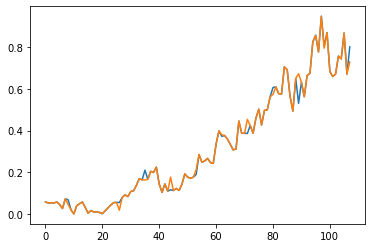

tensor([[0.0450]], grad_fn=<AddmmBackward0>)
AAAAA
tensor([[0.0574, 0.0526, 0.0532, 0.0526, 0.0574, 0.0446, 0.0259, 0.0728]])
tensor([[0.0090]], grad_fn=<AddmmBackward0>)
AAAAA
tensor([[0.0194, 0.0000, 0.0397, 0.0491, 0.0573, 0.0311, 0.0034, 0.0163]])
tensor([[0.0180]], grad_fn=<AddmmBackward0>)
AAAAA
tensor([[0.0105, 0.0069, 0.0010, 0.0149, 0.0291, 0.0432, 0.0543, 0.0553]])
tensor([[0.1631]], grad_fn=<AddmmBackward0>)
AAAAA
tensor([[0.0794, 0.0916, 0.0831, 0.1078, 0.1111, 0.1376, 0.1693, 0.1638]])
tensor([[0.1768]], grad_fn=<AddmmBackward0>)
AAAAA
tensor([[0.1663, 0.2047, 0.1990, 0.2246, 0.1437, 0.1035, 0.1441, 0.1093]])
tensor([[0.2124]], grad_fn=<AddmmBackward0>)
AAAAA
tensor([[0.1122, 0.1224, 0.1130, 0.1426, 0.1924, 0.1768, 0.1713, 0.1764]])
tensor([[0.3804]], grad_fn=<AddmmBackward0>)
AAAAA
tensor([[0.2852, 0.2488, 0.2540, 0.2668, 0.2471, 0.2425, 0.3356, 0.3986]])
tensor([[0.4542]], grad_fn=<AddmmBackward0>)
AAAAA
tensor([[0.3764, 0.3593, 0.3339, 0.3078, 0.3113, 0.4461, 0.3875, 0.

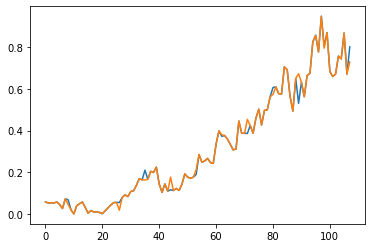

[0.81280927 0.86488167 0.80708521 0.79440233 0.75323313 0.60158617
 0.82804043 0.80158034 0.69185568 0.71781569 0.75158265 0.689009
 0.6259552  0.71098042 0.66563454 0.76420858 0.72824393 0.70097231
 0.72644053 0.76779128 0.75298823 0.78775683 0.6913776  0.69977333
 0.60954454 0.7166723  0.69280521 0.59122007 0.65289663 0.63678634
 0.62863523 0.5897861  0.65217408 0.45366899 0.5944051  0.50599046
 0.53791292 0.49539961 0.29700349 0.30497147 0.32464658 0.33062864
 0.31132227 0.39851368 0.44343923 0.38416685 0.40155024 0.392112
 0.40155024 0.38416685]


In [ ]:
plt.plot(range(108), entrenamiento[0][:-8])
plt.plot(range(108), genera_prediccion(pruebas_ordenadas[0]).detach().numpy().tolist()[0])
plt.show()

plt.plot(range(108), entrenamiento[0][:-8])
plt.plot(range(108), [desnormalizar(vect) for vect in genera_prediccion(pruebas_ordenadas[0]).detach().numpy().tolist()[0]])
# Mostrar el gráfico
plt.show()
#investigar bien la dwt y predecir la red con los corrimientos de 1, usando los datos que predice o solo los datos que le doy

print(prueba[0])

In [ ]:
print(entrenamiento[0])

[5.74190669e-02 5.26115427e-02 5.32059472e-02 5.26115427e-02
 5.74190669e-02 4.46451474e-02 2.59076435e-02 7.28480379e-02
 6.75467168e-02 1.94183370e-02 0.00000000e+00 3.96559539e-02
 4.90910467e-02 5.73483932e-02 3.11287281e-02 3.36716612e-03
 1.63431954e-02 8.81023796e-03 1.05414503e-02 6.91448943e-03
 9.88236743e-04 1.49402544e-02 2.90813332e-02 4.32049920e-02
 5.43044829e-02 5.52902327e-02 5.47576127e-02 7.93668482e-02
 9.16296810e-02 8.30955579e-02 1.07836425e-01 1.11088776e-01
 1.37641958e-01 1.69316125e-01 1.63832237e-01 2.10289083e-01
 1.66266282e-01 2.04671727e-01 1.98989487e-01 2.24553101e-01
 1.43670582e-01 1.03548140e-01 1.44054318e-01 1.09303072e-01
 1.16019676e-01 1.12235862e-01 1.22356549e-01 1.13023853e-01
 1.42607025e-01 1.92364016e-01 1.76815541e-01 1.71315259e-01
 1.76417932e-01 1.89529364e-01 2.85232753e-01 2.48810873e-01
 2.53982701e-01 2.66836692e-01 2.47067044e-01 2.42507459e-01
 3.35618986e-01 3.98599748e-01 3.72859327e-01 3.76405905e-01
 3.59270542e-01 3.338747

116
>>>>>>i: 0
Nueva Entrada:
tensor([0.0574, 0.0526, 0.0532, 0.0526, 0.0574, 0.0446, 0.0259, 0.0728])
Prediction: 0.04501858353614807
[0.05261154 0.05320595 0.05261154 0.05741907 0.04464515 0.02590764
 0.07284804 0.04501858]
>>>>>>i: 1
Nueva Entrada:
tensor([0.0526, 0.0532, 0.0526, 0.0574, 0.0446, 0.0259, 0.0728, 0.0450])
Prediction: 0.03493836522102356
[0.05320595 0.05261154 0.05741907 0.04464515 0.02590764 0.07284804
 0.04501858 0.03493837]
>>>>>>i: 2
Nueva Entrada:
tensor([0.0532, 0.0526, 0.0574, 0.0446, 0.0259, 0.0728, 0.0450, 0.0349])
Prediction: 0.029881566762924194
[0.05261154 0.05741907 0.04464515 0.02590764 0.07284804 0.04501858
 0.03493837 0.02988157]
>>>>>>i: 3
Nueva Entrada:
tensor([0.0526, 0.0574, 0.0446, 0.0259, 0.0728, 0.0450, 0.0349, 0.0299])
Prediction: 0.028440147638320923
[0.05741907 0.04464515 0.02590764 0.07284804 0.04501858 0.03493837
 0.02988157 0.02844015]
>>>>>>i: 4
Nueva Entrada:
tensor([0.0574, 0.0446, 0.0259, 0.0728, 0.0450, 0.0349, 0.0299, 0.0284])
Predict

Nueva Entrada:
tensor([ 0.0284,  0.0232,  0.0135,  0.0017, -0.0065, -0.0194, -0.0348, -0.0529])
Prediction: -0.07369658350944519
[ 0.02318773  0.01349536  0.0017387  -0.00654748 -0.01942644 -0.03481469
 -0.05292752 -0.07369658]
>>>>>>i: 12
Nueva Entrada:
tensor([ 0.0232,  0.0135,  0.0017, -0.0065, -0.0194, -0.0348, -0.0529, -0.0737])
Prediction: -0.09838709235191345
[ 0.01349536  0.0017387  -0.00654748 -0.01942644 -0.03481469 -0.05292752
 -0.07369658 -0.09838709]
>>>>>>i: 13
Nueva Entrada:
tensor([ 0.0135,  0.0017, -0.0065, -0.0194, -0.0348, -0.0529, -0.0737, -0.0984])
Prediction: -0.1281912624835968
[ 0.0017387  -0.00654748 -0.01942644 -0.03481469 -0.05292752 -0.07369658
 -0.09838709 -0.12819126]
>>>>>>i: 14
Nueva Entrada:
tensor([ 0.0017, -0.0065, -0.0194, -0.0348, -0.0529, -0.0737, -0.0984, -0.1282])
Prediction: -0.16413405537605286
[-0.00654748 -0.01942644 -0.03481469 -0.05292752 -0.07369658 -0.09838709
 -0.12819126 -0.16413406]
>>>>>>i: 15
Nueva Entrada:
tensor([-0.0065, -0.0194, 

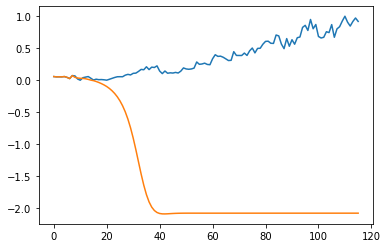

[ 5.74190669e-02  5.26115427e-02  5.32059472e-02  5.26115427e-02
  5.74190669e-02  4.46451474e-02  2.59076435e-02  7.28480379e-02
  4.50185835e-02  3.49383652e-02  2.98815668e-02  2.84401476e-02
  2.31877267e-02  1.34953558e-02  1.73869729e-03 -6.54748082e-03
 -1.94264352e-02 -3.48146856e-02 -5.29275239e-02 -7.36965835e-02
 -9.83870924e-02 -1.28191262e-01 -1.64134055e-01 -2.07067221e-01
 -2.59084731e-01 -3.22357684e-01 -3.99507016e-01 -4.93458241e-01
 -6.07363820e-01 -7.43839979e-01 -9.03591037e-01 -1.08352947e+00
 -1.27532589e+00 -1.46579921e+00 -1.64029145e+00 -1.78732073e+00
 -1.90137303e+00 -1.98273194e+00 -2.03570771e+00 -2.06665635e+00
 -2.08225155e+00 -2.08824277e+00 -2.08891749e+00 -2.08712578e+00
 -2.08456826e+00 -2.08212829e+00 -2.08017540e+00 -2.07878804e+00
 -2.07789874e+00 -2.07738900e+00 -2.07713771e+00 -2.07704544e+00
 -2.07704020e+00 -2.07707405e+00 -2.07711959e+00 -2.07716155e+00
 -2.07719493e+00 -2.07721853e+00 -2.07723355e+00 -2.07724166e+00
 -2.07724571e+00 -2.07724

In [ ]:


def genera_salida(vect):
    #print(vect)
    print(len(vect))
    c = vect[:8]
    o = vect[:8]
    copia_prueba_0 = vect.copy()
    for i in range(len(vect)-7):
        print(">>>>>>i: " + str(i))
        print("Nueva Entrada:")
        print(torch.Tensor(c))
        predicted_output = red_A1(torch.Tensor(c))
        print("Prediction: " + str(predicted_output.item()))
        if(i+8 < len(vect)):
            copia_prueba_0[i+8]=predicted_output.item()
            c = np.concatenate((np.array(copia_prueba_0[i+1:i+8]),np.array([predicted_output.item()])))
            o = np.concatenate((np.array(o),np.array([predicted_output.item()])))
            #print([predicted_output.item()])
            #print(prueba[0][i:i+7])
            print(np.concatenate((np.array(copia_prueba_0[i+1:i+8]),np.array([predicted_output.item()]))))

    return o

salida = genera_salida(entrenamiento[0])


plt.plot(range(116), entrenamiento[0])
plt.plot(range(116), salida)
plt.show()

print(salida)
